# Piotruś i Wilk: Realistyczne Środowisko

W naszej sytuacji Piotruś mógł poruszać się prawie bez zmęczenia czy głodu. W bardziej realistycznym świecie musi od czasu do czasu usiąść i odpocząć, a także coś zjeść. Uczyńmy nasz świat bardziej realistycznym, wprowadzając następujące zasady:

1. Przemieszczając się z jednego miejsca do drugiego, Piotruś traci **energię** i zyskuje trochę **zmęczenia**.
2. Piotruś może odzyskać energię, jedząc jabłka.
3. Piotruś może pozbyć się zmęczenia, odpoczywając pod drzewem lub na trawie (czyli wchodząc na pole planszy z drzewem lub trawą - zielone pole).
4. Piotruś musi znaleźć i zabić wilka.
5. Aby zabić wilka, Piotruś musi mieć odpowiedni poziom energii i zmęczenia, w przeciwnym razie przegra walkę.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

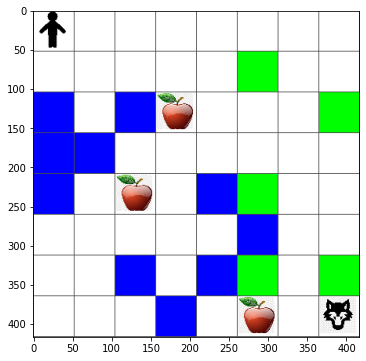

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definiowanie stanu

W naszych nowych zasadach gry musimy śledzić poziomy energii i zmęczenia na każdym etapie gry. Dlatego stworzymy obiekt `state`, który będzie przechowywał wszystkie potrzebne informacje o bieżącym stanie problemu, w tym stan planszy, aktualne poziomy energii i zmęczenia oraz informację, czy możemy pokonać wilka w stanie końcowym:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Spróbujmy rozwiązać problem za pomocą losowego marszu i zobaczyć, czy nam się uda:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Funkcja nagrody

### Wprowadzenie
Funkcja nagrody jest kluczowym elementem w @@INLINE_CODE_1@@, który określa, jak agent ocenia swoje działania. Poprawnie zaprojektowana funkcja nagrody może znacząco wpłynąć na efektywność uczenia się.

### Podstawowe zasady projektowania
- **Zdefiniuj jasne cele**: Funkcja nagrody powinna odzwierciedlać cele, które agent ma osiągnąć.
- **Unikaj sprzecznych sygnałów**: Sprzeczne nagrody mogą prowadzić do niepożądanych zachowań.
- **Skaluj nagrody odpowiednio**: Zbyt duże lub zbyt małe wartości mogą wpłynąć na stabilność procesu uczenia.

### Przykład funkcji nagrody
Poniżej znajduje się przykład funkcji nagrody w @@INLINE_CODE_2@@:

```python
def reward_function(params):
    # Pobierz parametry środowiska
    speed = params['speed']
    distance_from_center = params['distance_from_center']
    track_width = params['track_width']
    
    # Oblicz nagrodę na podstawie odległości od środka toru
    if distance_from_center < 0.1 * track_width:
        reward = 1.0
    else:
        reward = 0.5
    
    # Dodaj dodatkową nagrodę za prędkość
    reward += speed * 0.1
    
    return reward
```

### Wskazówki
[!TIP] Testuj funkcję nagrody w różnych scenariuszach, aby upewnić się, że agent uczy się właściwych zachowań.

[!WARNING] Uważaj na nadmierne nagradzanie jednego aspektu, co może prowadzić do ignorowania innych ważnych czynników.

### Częste błędy
- **Zbyt skomplikowana funkcja nagrody**: Może utrudnić agentowi zrozumienie, co jest ważne.
- **Brak testowania**: Funkcja nagrody powinna być dokładnie przetestowana przed wdrożeniem.

### Podsumowanie
Funkcja nagrody jest kluczowym narzędziem w @@INLINE_CODE_3@@, które pomaga agentowi osiągnąć zamierzone cele. Starannie zaprojektowana funkcja nagrody zwiększa szanse na sukces w procesie uczenia.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algorytm Q-Learning

Sam algorytm uczenia pozostaje praktycznie niezmieniony, używamy tylko `state` zamiast samej pozycji na planszy.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

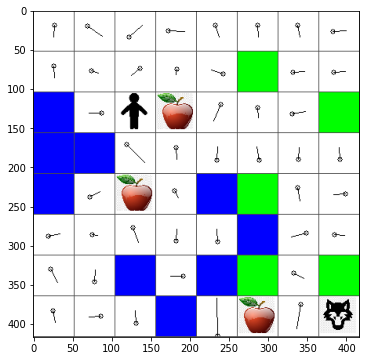

In [11]:
m.plot(Q)

## Wyniki

Zobaczmy, czy udało nam się nauczyć Piotra walczyć z wilkiem!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Obecnie widzimy znacznie mniej przypadków utonięć, ale Peter wciąż nie zawsze jest w stanie zabić wilka. Spróbuj eksperymentować i sprawdź, czy możesz poprawić ten wynik, manipulując hiperparametrami.


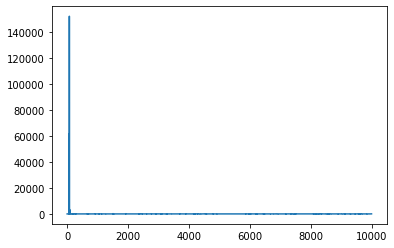

In [13]:
plt.plot(lpath)


---

**Zastrzeżenie**:  
Ten dokument został przetłumaczony za pomocą usługi tłumaczenia AI [Co-op Translator](https://github.com/Azure/co-op-translator). Chociaż dokładamy wszelkich starań, aby tłumaczenie było precyzyjne, prosimy pamiętać, że automatyczne tłumaczenia mogą zawierać błędy lub nieścisłości. Oryginalny dokument w jego rodzimym języku powinien być uznawany za źródło autorytatywne. W przypadku informacji o kluczowym znaczeniu zaleca się skorzystanie z profesjonalnego tłumaczenia przez człowieka. Nie ponosimy odpowiedzialności za jakiekolwiek nieporozumienia lub błędne interpretacje wynikające z użycia tego tłumaczenia.
